**<span style="color: gray;">In The Name of God</span>**

---


**<span style="color: #808080;">Mani hosseini</span>**<br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102552</span>**<br>
**<span style="color: #808080;">Parsa Bukani</span>** <br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102501</span>**<br>
**<span style="color: #808080;">Erfan Falahati</span>**<br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102491</span>**


# **<span style="color: #808080;">Task 2 - Semantic Search</span>**

In [43]:
import os
import re
import ast
import json
import pandas as pd
import seaborn as sns
import arabic_reshaper
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from bidi.algorithm import get_display
from hazm import Normalizer, Lemmatizer, word_tokenize, stopwords_list

plt.rcParams['font.family'] = 'DejaVu Sans'

FONT_PATH = os.path.join('content', 'Vazir.ttf')
PERCQA_FILE_PATH = os.path.join('content', 'PerCQA_JSON_Format.json')
DATASET_PATH = os.path.join('content', 'Q&A.csv')
PREPROCESSED_DATASET_PATH = os.path.join('content', 'preprocessed_Q&A.csv')

# **<span style="color: coral;">Read data from PerCQA file</span>**

In [3]:
with open(PERCQA_FILE_PATH, 'r', encoding='utf-8-sig') as f:
        data = json.load(f)

rows = []

for item in data:
    question_id = item.get("QID")
    question_body = item.get("QBody")
    question_subject = item.get("QSubject")
    question_user = item.get("QUsername")
    question_date = item.get("QDATE")

    comments = item.get("Comments", [])
    for comment in comments:
          rows.append({
            "question_id": question_id,
            "question_subject": question_subject,
            "question_body": question_body,
            "question_user": question_user,
            "question_date": question_date,
            "answer_id": comment.get("CID"),
            "answer_body": comment.get("CBody"),
            "answer_clean": comment.get("CBodyClean"),
            "answer_user": comment.get("CUsername"),
            "answer_date": comment.get("LabelDate"),
            "gold_label": comment.get("CGOLD"),
        })
          
df = pd.DataFrame(rows)
df.to_csv(DATASET_PATH, index=False)

￼Get Plus
￼
What
print(df.shape)
df.head()

SyntaxError: invalid character '￼' (U+FFFC) (985514734.py, line 32)

# **<span style="color: coral;">Preprocessing</span>**

In [44]:
df = pd.read_csv(DATASET_PATH)

## **<span style="color: #808080;">Normalize Persian and Arabic characters</span>**

In [45]:
def normalize_arabic_chars(text: str):
    replacements = {
        'ي': 'ی',
        'ك': 'ک',
        'ة': 'ه',
        'ۀ': 'ه',
        'ؤ': 'و',
        'إ': 'ا',
        'أ': 'ا',
        'آ': 'ا',
        '\u200c': ' ',
        '\u200b': ''
    }
    for arabic_char, persian_char in replacements.items():
        text = text.replace(arabic_char, persian_char)
    return text

def clean_punctuation_spaces(text: str):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    text = re.sub(r'([؟!.,]){2,}', r'\1', text)
    
    text = re.sub(r'\s+', ' ', text).strip()

    return text

normalizer = Normalizer()

def preprocess(text: str):
    if not isinstance(text, str):
        return ""
    text = normalize_arabic_chars(text)
    text = clean_punctuation_spaces(text)
    text = normalizer.normalize(text)
    return text

In [46]:
df["clean_question"] = df["question_body"].apply(preprocess)
df["clean_answer"] = df["answer_clean"].apply(preprocess)

## **<span style="color: #808080;">Remove diacritics and unwanted characters</span>**

In [47]:
texts = pd.concat([df['clean_question'], df['clean_answer']]).dropna().unique()

diacritics = [
    '\u064b', '\u064c', '\u064d', '\u064e', '\u064f',
    '\u0650', '\u0651', '\u0652', '\u0670'
]

found_diacritics = set()
for text in texts:
    for d in diacritics:
        if d in text:
            found_diacritics.add(d)

print("Diacritics found in data:", found_diacritics)


Diacritics found in data: set()


In [48]:
def remove_diacritics(text: str):
    diacritics_pattern = re.compile(
        r'[\u064b-\u0652\u0670]', flags=re.UNICODE)
    return diacritics_pattern.sub('', text)


## **<span style="color: #808080;">Tokenization</span>**

In [49]:
def tokenize_text(text: str):
    if not isinstance(text, str):
        return []
    
    tokens = word_tokenize(text)
    return tokens

In [50]:
df['question_tokens'] = df['clean_question'].apply(tokenize_text)
df['answer_tokens'] = df['answer_clean'].apply(tokenize_text)

## **<span style="color: #808080;">Remove stopwords</span>**

In [51]:
stopwords = set(stopwords_list())
print("Number of stopwords:", len(stopwords))
print("Sample:", list(stopwords)[:10])

def remove_stopwords(tokens: list):
    if not isinstance(tokens, list):
        return []
    return [word for word in tokens if word not in stopwords]



Number of stopwords: 389
Sample: ['یک', 'هنگام', 'بوده_است', 'می\u200cشوند', 'تغییر', 'دیگر', 'ساز', 'ممکن', 'تعیین', 'فقط']


In [52]:
df['question_tokens_with_stopwords'] = df['question_tokens']
df['answer_tokens_with_stopwords'] = df['answer_tokens']

df['question_tokens'] = df['question_tokens'].apply(remove_stopwords)
df['answer_tokens'] = df['answer_tokens'].apply(remove_stopwords)

## **<span style="color: #808080;">Stemming and Lemmatization</span>**

In [53]:
lemmatizer = Lemmatizer()

def lemmatize(tokens: list):
    if not isinstance(tokens, list):
        return []
    return [lemmatizer.lemmatize(word).split('#')[0] for word in tokens]

In [54]:
df['question_tokens'] = df['question_tokens'].apply(lemmatize)
df['answer_tokens'] = df['answer_tokens'].apply(lemmatize)

df['question_tokens_with_stopwords'] = df['question_tokens_with_stopwords'].apply(lemmatize)
df['answer_tokens_with_stopwords'] = df['answer_tokens_with_stopwords'].apply(lemmatize)

## **<span style="color: #808080;">Normalize informal stretching and repetition</span>**

In [55]:
def reduce_letter_repetition(tokens: list):
    if not isinstance(tokens, list):
        return []
    return [re.sub(r'(.)\1{2,}', r'\1\1', word) for word in tokens]

In [56]:
df['question_tokens'] = df['question_tokens'].apply(reduce_letter_repetition)
df['answer_tokens'] = df['answer_tokens'].apply(reduce_letter_repetition)

df['question_tokens_with_stopwords'] = df['question_tokens_with_stopwords'].apply(reduce_letter_repetition)
df['answer_tokens_with_stopwords'] = df['answer_tokens_with_stopwords'].apply(reduce_letter_repetition)

## **<span style="color: #808080;">Replace informal or slang expressions</span>**

In [57]:
slang_dict = {
    'خخخ': 'خنده',
    'عه': 'تعجب',
    'عهه': 'تعجب',
    'عههه': 'تعجب',
    'عهههه': 'تعجب',
    'اووف': 'ناراحتی',
    'اوووف': 'ناراحتی',
    'وای': 'تعجب',
    'ایشالا': 'ان‌شاءالله',
    'انشالا': 'ان‌شاءالله',
    'الهییی': 'دلسوزی',
}

def replace_slang(tokens: list):
    return [slang_dict.get(word, word) for word in tokens]

In [58]:
df['question_tokens'] = df['question_tokens'].apply(replace_slang)
df['answer_tokens'] = df['answer_tokens'].apply(replace_slang)

df['question_tokens_with_stopwords'] = df['question_tokens_with_stopwords'].apply(replace_slang)
df['answer_tokens_with_stopwords'] = df['answer_tokens_with_stopwords'].apply(replace_slang)

## **<span style="color: #808080;">Displaying Persian Text Correctly</span>**

In [59]:
def reshape_and_display_persian(text: str):
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text

In [60]:
sample_text = "تست متن فارسی."
print(sample_text)
print(reshape_and_display_persian(sample_text))

تست متن فارسی.
.ﯽﺳﺭﺎﻓ ﻦﺘﻣ ﺖﺴﺗ


## **<span style="color: #808080;">Save preprocessed data</span>**

In [61]:
df.to_csv(PREPROCESSED_DATASET_PATH, index=False)

# **<span style="color: coral;">EDA</span>**

## **<span style="color: #808080;">Load preprocessed data</span>**

In [62]:
df = pd.read_csv(PREPROCESSED_DATASET_PATH)

## **<span style="color: #808080;">Understand the structure of questions and answers</span>**

In [23]:
sample_rows = df.sample(n=2, random_state=1200)

for i, (_, row) in enumerate(sample_rows.iterrows(), 1):
    print(f"Question {i}: {row['question_body']}\n")
    print(f"Answers: {i}: {row['answer_body']}")
    print("" + "-"*80 + "\n")

Question 1: شوهرتون ماشین جدید بخره ناراحت میشید به نام شما نزنه؟ . من ناراحتم خب . مثلا خاست سورپرایز شم اصلا هیچی نگف بم . به شوخی گفتم نمیخای سندشو به نامم بزنی گف این حرفا چیه دگ . البته ما تو عقدیم هنو

Answers: 1: بالاخره ببخش. انصافا یکم ناراحت شدم شاید بد حرف زدم خواهر. حلال کن
--------------------------------------------------------------------------------

Question 2: دستم به دامنتون.  تا حالا هیج خواستگاری و راه ندادیم این مورد چون جدییه ، اولین نفره خیلیی استرس دارم که چه رفتاری باید نشون بدم جی بگم و . بعد اینکه چند بعد بله برون میبرن دخترو گواهی سلامت بگیره؟ خیلی خجالت میکشم و بدم میاد از اینکار اگه بهم گفتن چی بگم . مادرم فوت شده .  نمیدونم باید این چیزارو از کی بپرسم رفتارم با مادر پسره چطور باشه؟ 

Answers: 2: . نه بیرون نشست ولی خیلی خجالت آور بود در ضمن بنظر من اگه خودت پیش پیش با شوهرت بری بد نمیشه واست بالاخره مردن دیگه موجودات عجیب غریب
--------------------------------------------------------------------------------



In [24]:
questions_df = df.drop_duplicates(subset='question_id')

question_word_lens = questions_df["question_body"].dropna().apply(lambda x: len(x.split()))
answer_word_lens = df["answer_body"].dropna().apply(lambda x: len(x.split()))

question_char_lens = questions_df["question_body"].dropna().apply(len)
answer_char_lens = df["answer_body"].dropna().apply(len)

print("🔹 Question Word Count → Avg:", round(question_word_lens.mean(), 2), 
      "Median:", round(question_word_lens.median(), 2))

print("🔹 Answer Word Count   → Avg:", round(answer_word_lens.mean(), 2), 
      "Median:", round(answer_word_lens.median(), 2))

print("🔸 Question Char Count → Avg:", round(question_char_lens.mean(), 2), 
      "Median:", round(question_char_lens.median(), 2))

print("🔸 Answer Char Count   → Avg:", round(answer_char_lens.mean(), 2), 
      "Median:", round(answer_char_lens.median(), 2))

🔹 Question Word Count → Avg: 35.1 Median: 26.0
🔹 Answer Word Count   → Avg: 19.29 Median: 13.0
🔸 Question Char Count → Avg: 172.93 Median: 129.0
🔸 Answer Char Count   → Avg: 97.24 Median: 67.0


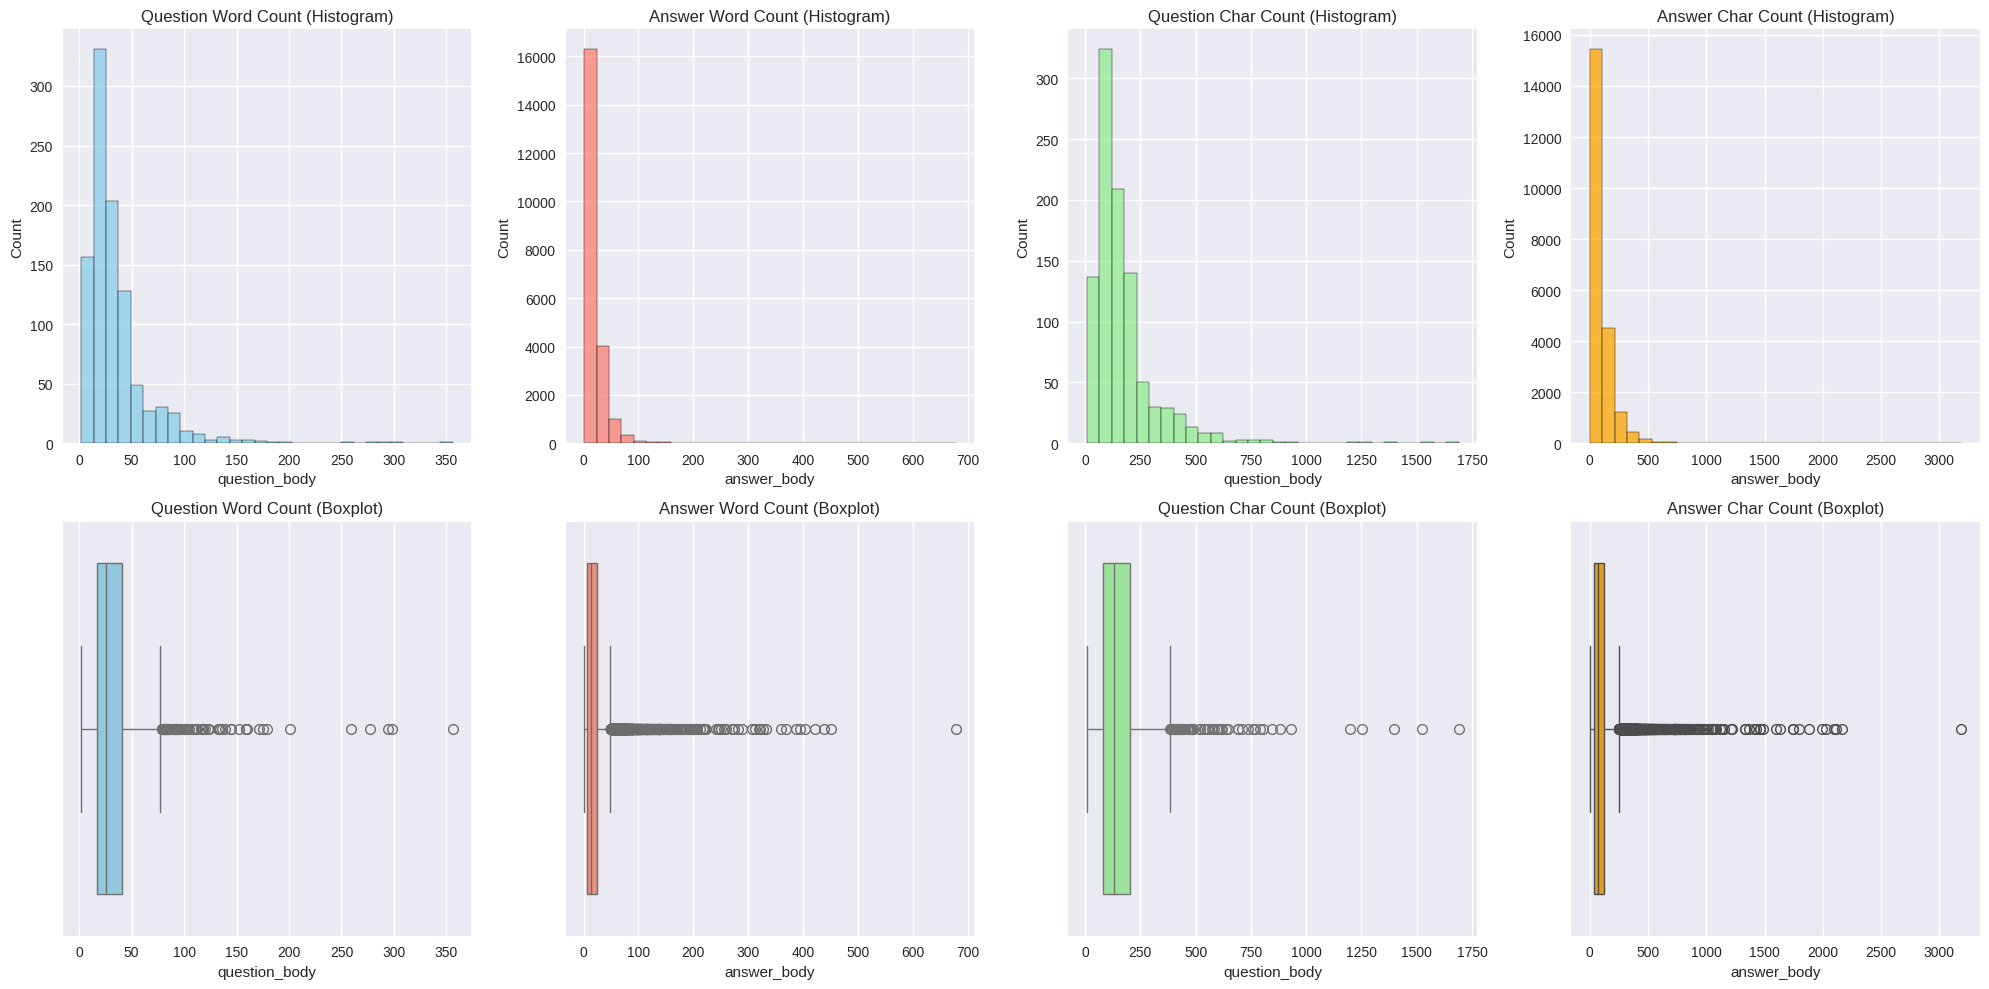

In [25]:
plt.style.use('seaborn-v0_8')

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

sns.histplot(question_word_lens, bins=30, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title("Question Word Count (Histogram)")
sns.histplot(answer_word_lens, bins=30, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title("Answer Word Count (Histogram)")

sns.boxplot(x=question_word_lens, ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title("Question Word Count (Boxplot)")
sns.boxplot(x=answer_word_lens, ax=axes[1, 1], color='salmon')
axes[1, 1].set_title("Answer Word Count (Boxplot)")

sns.histplot(question_char_lens, bins=30, ax=axes[0, 2], color='lightgreen')
axes[0, 2].set_title("Question Char Count (Histogram)")
sns.histplot(answer_char_lens, bins=30, ax=axes[0, 3], color='orange')
axes[0, 3].set_title("Answer Char Count (Histogram)")

sns.boxplot(x=question_char_lens, ax=axes[1, 2], color='lightgreen')
axes[1, 2].set_title("Question Char Count (Boxplot)")
sns.boxplot(x=answer_char_lens, ax=axes[1, 3], color='orange')
axes[1, 3].set_title("Answer Char Count (Boxplot)")

plt.tight_layout()
plt.show()


## **<span style="color: #808080;">Identify the most engaging questions</span>**

In [26]:
answer_counts = df.groupby("question_id")["answer_id"].count().sort_values(ascending=False)

top_questions = answer_counts.head(10)
print("Top 10 Most Answered Questions:\n", top_questions)

top_q_data = df[df["question_id"].isin(top_questions.index)][["question_id", "question_subject"]].drop_duplicates()
top_q_data = top_q_data.merge(top_questions, on="question_id")

top_q_data.columns = ["question_id", "question_subject", "answer_count"]

Top 10 Most Answered Questions:
 question_id
1556257    315
1577970    313
1555428    215
1559359    215
1578477    166
1569562    144
1591164    143
1567278    137
1585904    137
1575297    136
Name: answer_id, dtype: int64


In [27]:
topic_stats = df.groupby('question_subject').agg(
    num_questions=('question_id', 'nunique'),
    total_answers=('answer_id', 'count'),
)

topic_stats['avg_answers_per_question'] = topic_stats['total_answers'] / topic_stats['num_questions']

topic_stats = topic_stats.sort_values(by='avg_answers_per_question', ascending=False).reset_index()


In [28]:
topic_stats.head(5)

,question_subject,num_questions,total_answers,avg_answers_per_question
0,با ١٥ ميليون چه چزایی برای جهازتون ميخرين؟,1,315,315.0
1,خواندن عقد توسط سید محمد خاتمی,1,313,313.0
2,کیا طلاق گرفتن...,1,215,215.0
3,گواهی سلامت برم بگیرم ؟,1,215,215.0
4,اونایی که شوهراشون خیلی نازشونو میکشه بیان,1,166,166.0


## **<span style="color: #808080;">Analyze user activity patterns:</span>**

In [29]:
df['answer_date'] = pd.to_datetime(df['answer_date'], errors='coerce')

In [30]:
df['hour'] = df['answer_date'].dt.hour
df['weekday'] = df['answer_date'].dt.day_of_week

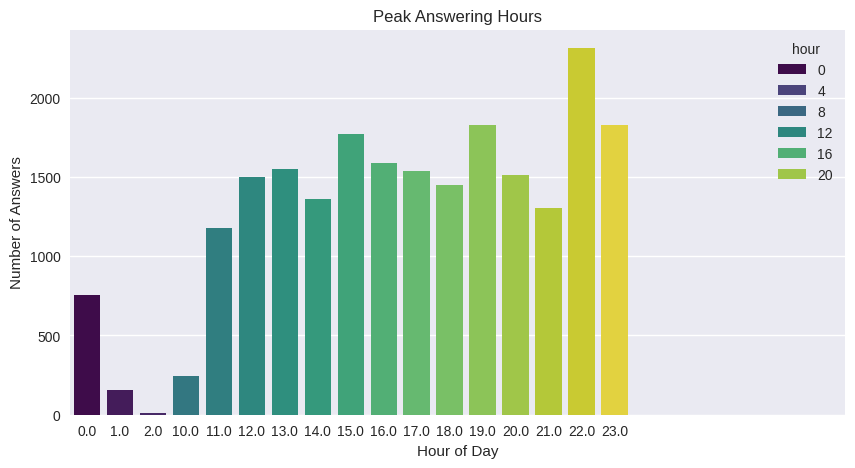

In [31]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='hour', hue='hour', palette='viridis')
plt.title('Peak Answering Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Answers')
plt.xticks(range(24))
plt.grid(True, axis='y')
plt.show()

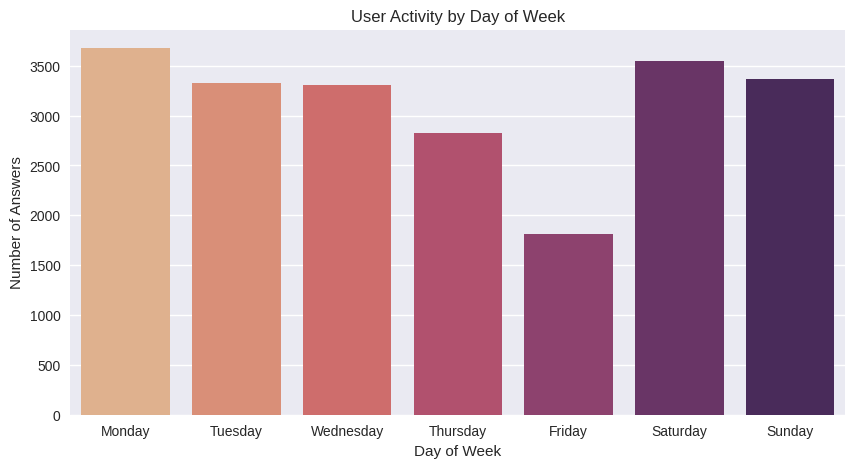

In [32]:
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='weekday', hue='weekday', palette='flare', legend=False)
plt.title('User Activity by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Answers')
plt.xticks(ticks=range(7), labels=day_labels)
plt.grid(True, axis='y')
plt.show()



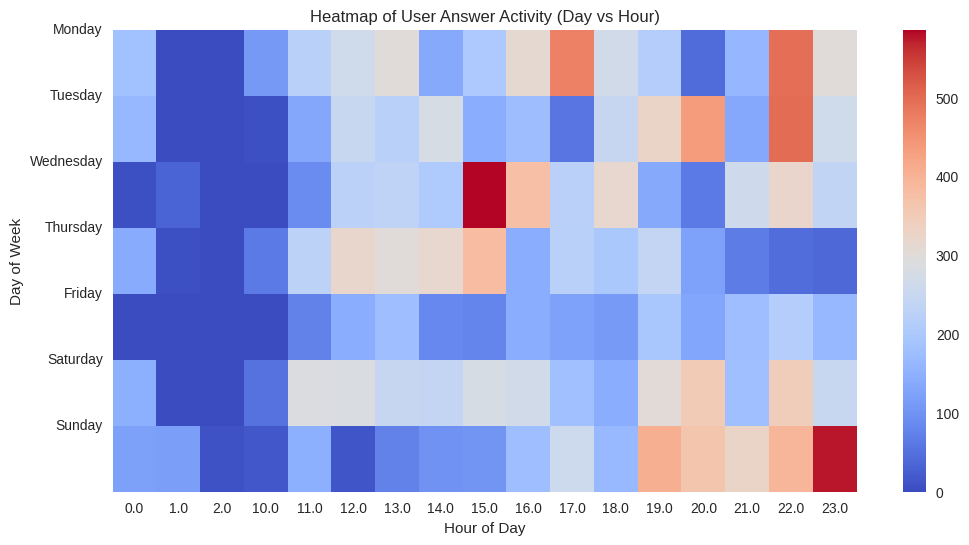

In [33]:
heatmap_data = df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm')
plt.title('Heatmap of User Answer Activity (Day vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=range(7), labels=day_labels, rotation=0)
plt.show()

## **<span style="color: #808080;">Detect top answer contributors</span>**

/tmp/ipykernel_21911/4197888643.py:11: UserWarning: Glyph 64508 (\N{ARABIC LETTER FARSI YEH ISOLATED FORM}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_21911/4197888643.py:11: UserWarning: Glyph 65197 (\N{ARABIC LETTER REH ISOLATED FORM}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_21911/4197888643.py:11: UserWarning: Glyph 65166 (\N{ARABIC LETTER ALEF FINAL FORM}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_21911/4197888643.py:11: UserWarning: Glyph 65260 (\N{ARABIC LETTER HEH MEDIAL FORM}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_21911/4197888643.py:11: UserWarning: Glyph 65169 (\N{ARABIC LETTER BEH INITIAL FORM}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_21911/4197888643.py:11: UserWarning: Glyph 65253 (\N{ARABIC LETTER NOON ISOLATED FORM}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_21911/4197888643.

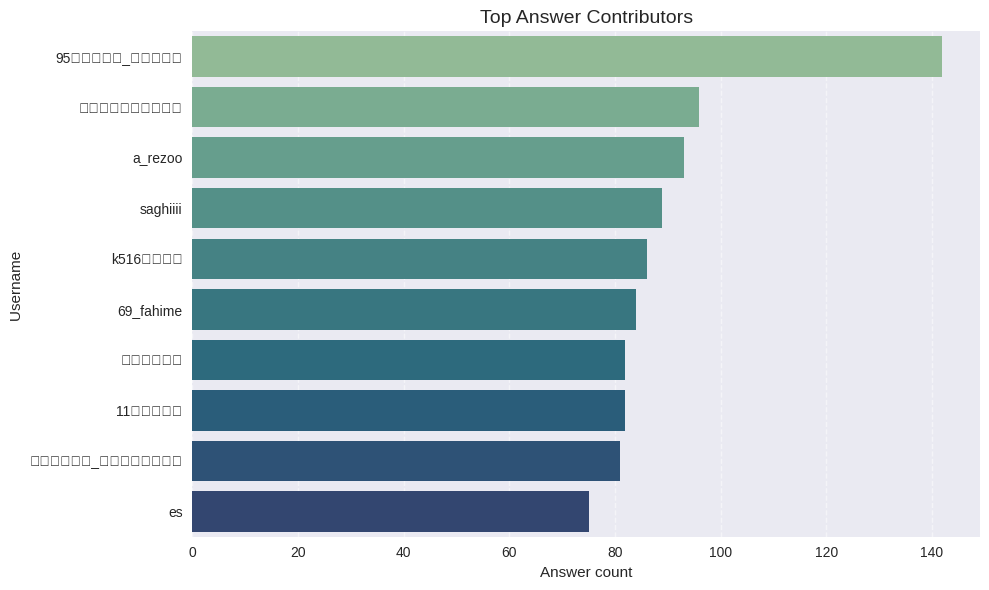

In [34]:
top_users = df['answer_user'].value_counts().head(10)
reshaped_labels = [reshape_and_display_persian(user) for user in top_users.index]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_users.values, y=reshaped_labels, hue=reshaped_labels, palette='crest')

plt.title('Top Answer Contributors', fontsize=14)
plt.xlabel('Answer count')
plt.ylabel('Username ')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## **<span style="color: #808080;">Linguistic and word-level analysis</span>**

### **Extract most frequent words**

In [63]:
question_words = [word for tokens in df['question_tokens'].dropna() for word in ast.literal_eval(tokens) if word not in {'.', '،', '؟'}]
answer_words = [word for tokens in df['answer_tokens'].dropna() for word in ast.literal_eval(tokens) if word not in {'.', '،', '؟'}]

q_word_freq = Counter(question_words)
a_word_freq = Counter(answer_words)

print("Top Question Words:", q_word_freq.most_common(10))
print("Top Answer Words:", a_word_freq.most_common(10))


Top Question Words: [('یه', 7151), ('داشت', 6378), ('میشه', 5079), ('داره', 5000), ('الان', 4855), ('زد', 4714), ('باشه', 4589), ('گرفت', 4587), ('نامزد', 4585), ('هست', 4567)]
Top Answer Words: [('یه', 3015), ('داشت', 2503), ('میشه', 2049), ('کن', 2000), ('داره', 1868), ('..', 1852), ('دیگه', 1844), ('بچه', 1805), ('عزیز', 1786), ('الان', 1668)]


### **Plot word frequencies**

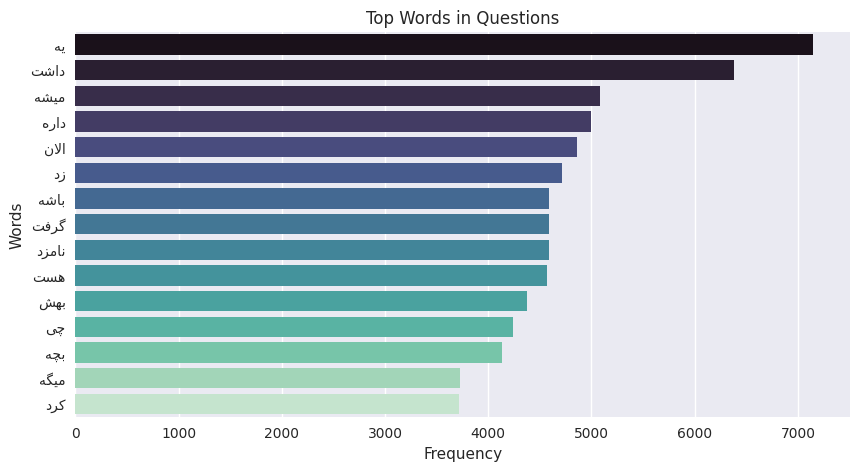

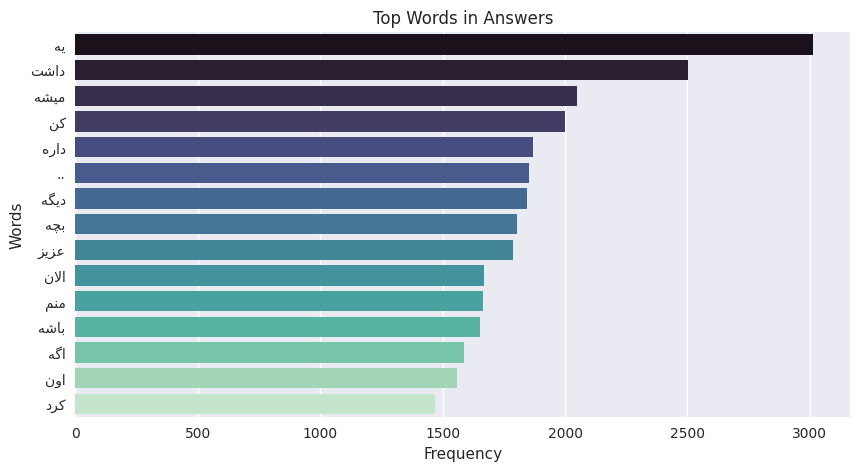

In [64]:
def plot_top_words(word_freq, title, n=15):
    filtered = [(word, freq) for word, freq in word_freq.most_common(n*2)]
    top = filtered[:n]

    words, freqs = zip(*top)
    
    reshaped_words = [reshape_and_display_persian(word) for word in words]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(freqs), y=list(reshaped_words), hue=list(reshaped_words), palette="mako")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show()

plot_top_words(q_word_freq, "Top Words in Questions")
plot_top_words(a_word_freq, "Top Words in Answers")


### **Generate Word Clouds**

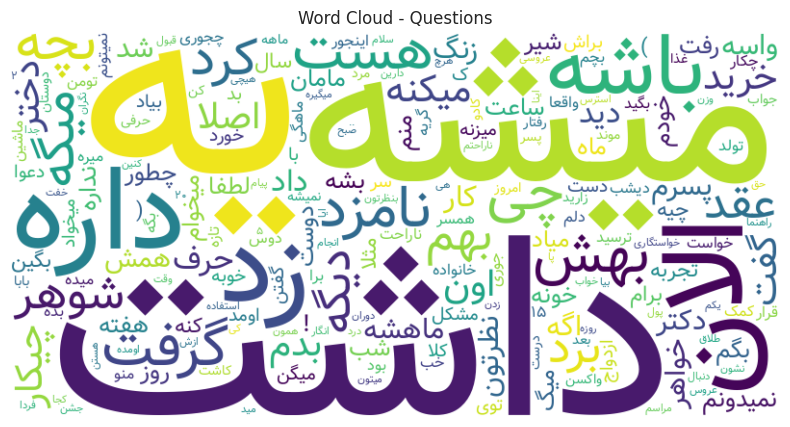

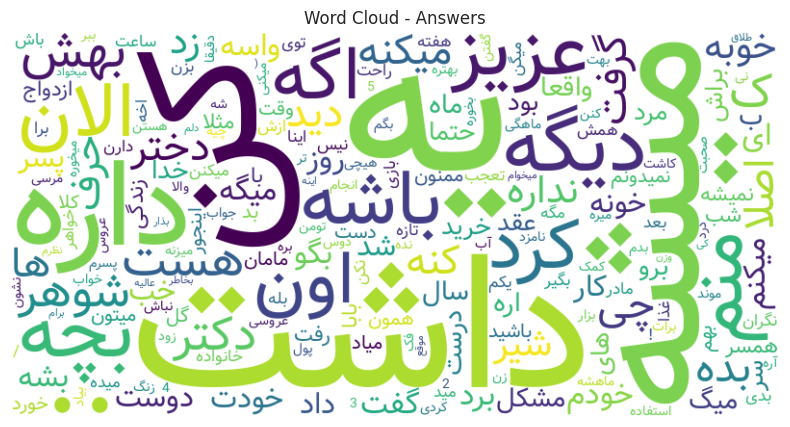

In [65]:
def show_wordcloud(freq, title):
    wc = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=400)
    wc.generate_from_frequencies(freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

show_wordcloud(q_word_freq, "Word Cloud - Questions")
show_wordcloud(a_word_freq, "Word Cloud - Answers")


### **N-gram Analysis**

In [66]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(texts, ngram_range=(1, 1), top_n=20):
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=10000)
    X = vectorizer.fit_transform(texts)
    sum_words = X.sum(axis=0)
    freqs = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    freqs = sorted(freqs, key=lambda x: x[1], reverse=True)
    return freqs[:top_n]


#### **Before remove the stopwords**

In [67]:
df['clean_question_str'] = df['question_tokens_with_stopwords'].dropna().apply(ast.literal_eval).apply(lambda x: ' '.join(x))
df['clean_answer_str'] = df['answer_tokens_with_stopwords'].dropna().apply(ast.literal_eval).apply(lambda x: ' '.join(x))

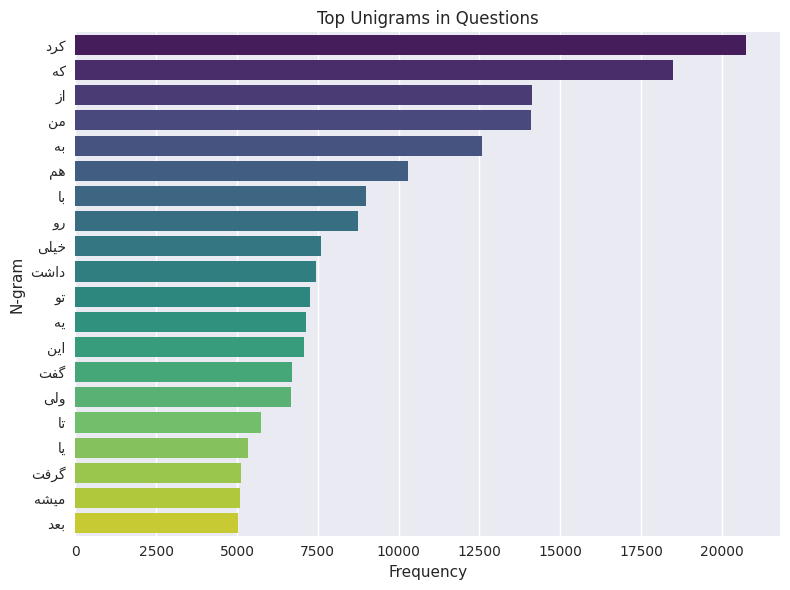

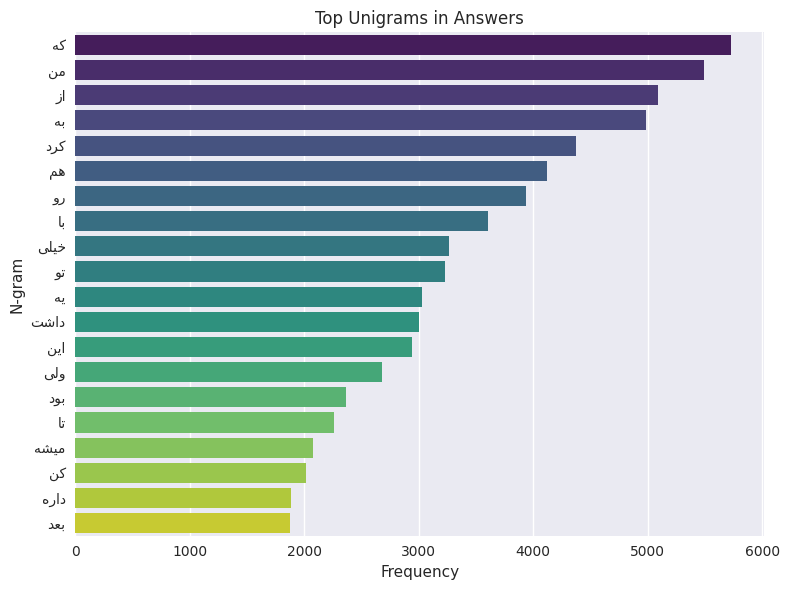

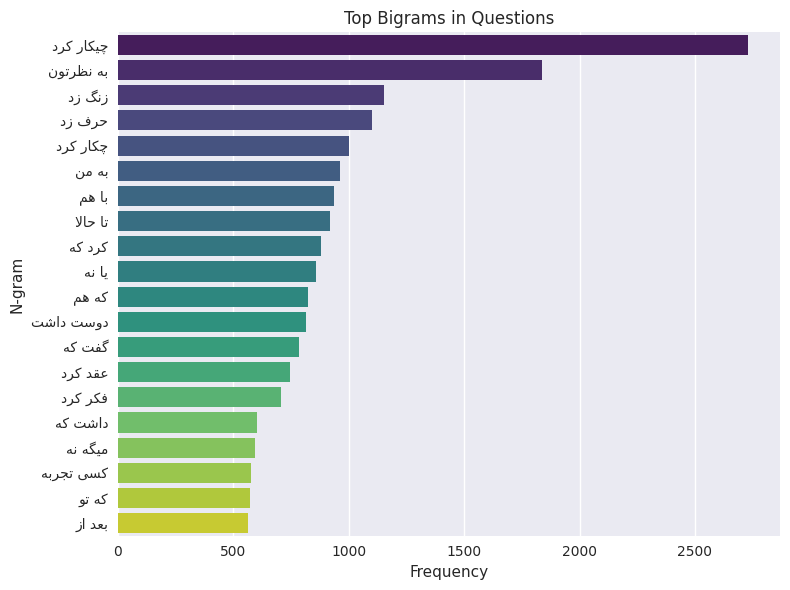

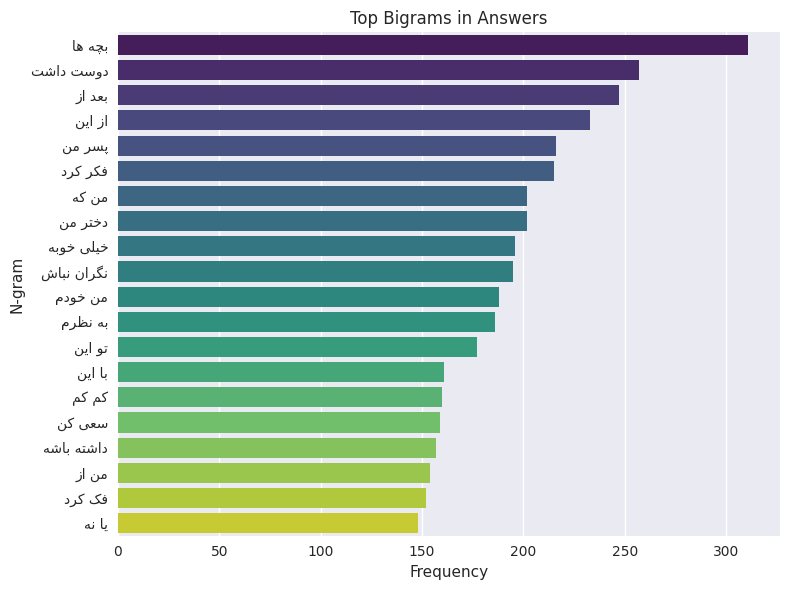

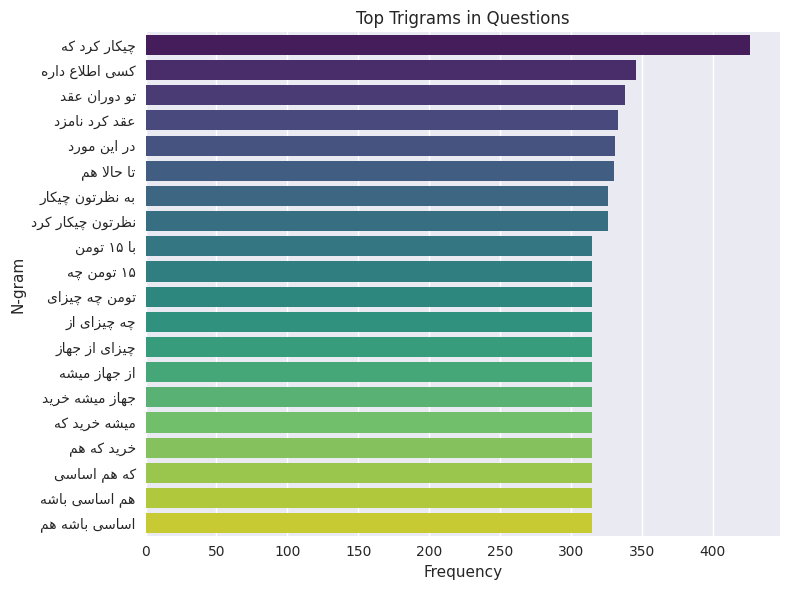

/tmp/ipykernel_21911/2919658540.py:9: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/erfan/.pyenv/versions/3.10.12/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


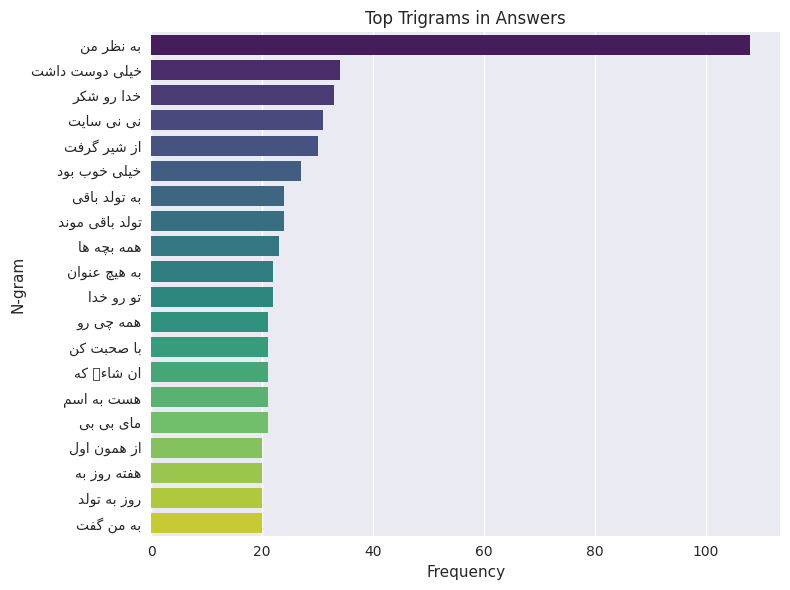

In [68]:
def plot_ngrams(ngrams, title):
    phrases, freqs = zip(*ngrams)
    reshaped_phrases = [reshape_and_display_persian(phrase) for phrase in phrases]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(freqs), y=reshaped_phrases, hue=reshaped_phrases, palette="viridis")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.tight_layout()
    plt.show()

q_unigrams = get_top_ngrams(df['clean_question_str'].dropna(), ngram_range=(1,1))
plot_ngrams(q_unigrams, "Top Unigrams in Questions")

a_unigrams = get_top_ngrams(df['clean_answer_str'].dropna(), ngram_range=(1,1))
plot_ngrams(a_unigrams, "Top Unigrams in Answers")

q_bigrams = get_top_ngrams(df['clean_question_str'].dropna(), ngram_range=(2,2))
plot_ngrams(q_bigrams, "Top Bigrams in Questions")

q_bigrams = get_top_ngrams(df['clean_answer_str'].dropna(), ngram_range=(2,2))
plot_ngrams(q_bigrams, "Top Bigrams in Answers")

q_bigrams = get_top_ngrams(df['clean_question_str'].dropna(), ngram_range=(3,3))
plot_ngrams(q_bigrams, "Top Trigrams in Questions")

a_trigrams = get_top_ngrams(df['clean_answer_str'].dropna(), ngram_range=(3,3))
plot_ngrams(a_trigrams, "Top Trigrams in Answers")


#### **After remove stopwords**

In [69]:
df['clean_question_str'] = df['question_tokens'].dropna().apply(ast.literal_eval).apply(lambda x: ' '.join(x))
df['clean_answer_str'] = df['answer_tokens'].dropna().apply(ast.literal_eval).apply(lambda x: ' '.join(x))

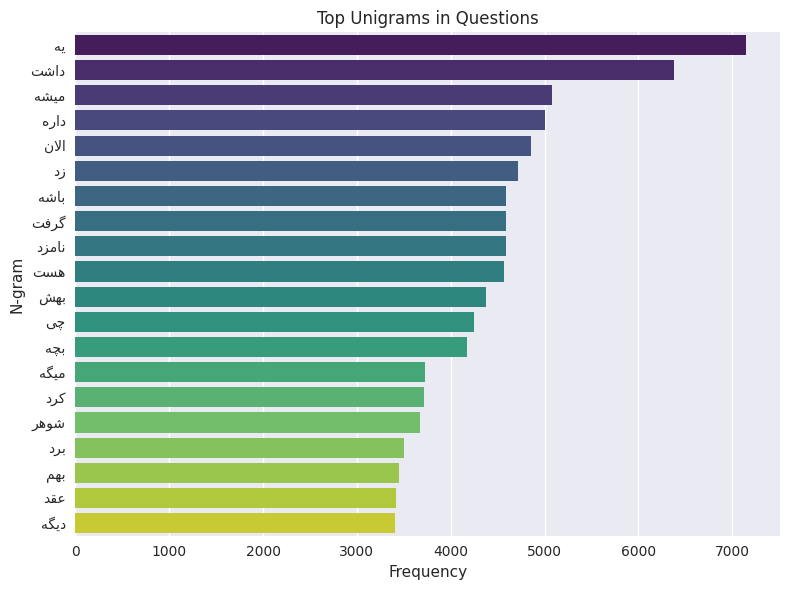

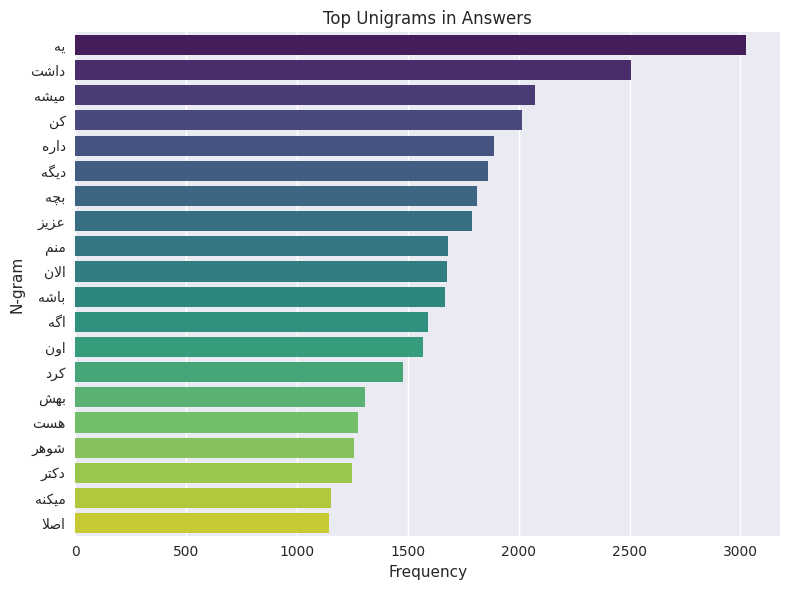

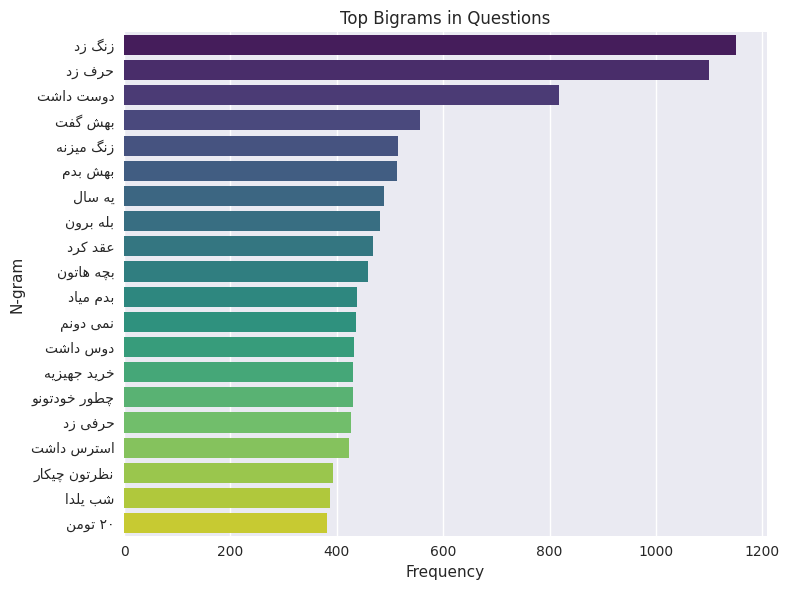

/tmp/ipykernel_21911/2919658540.py:9: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/erfan/.pyenv/versions/3.10.12/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


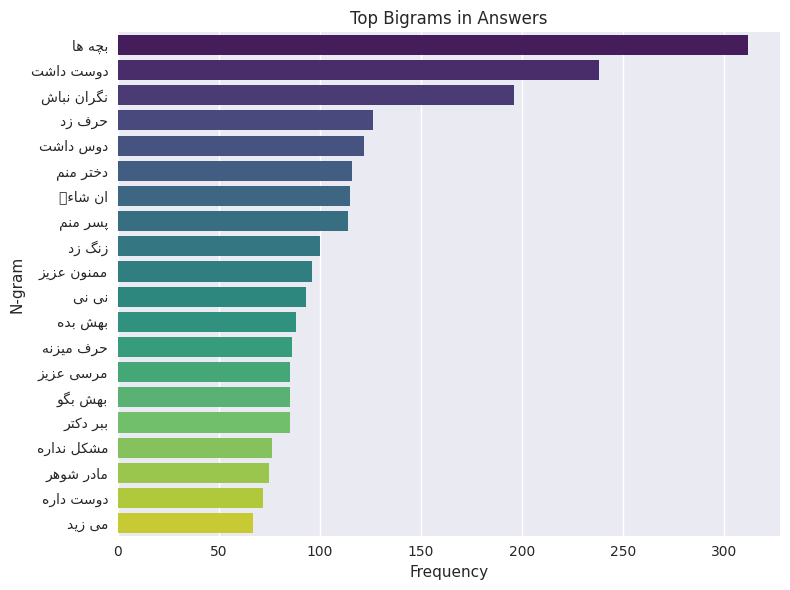

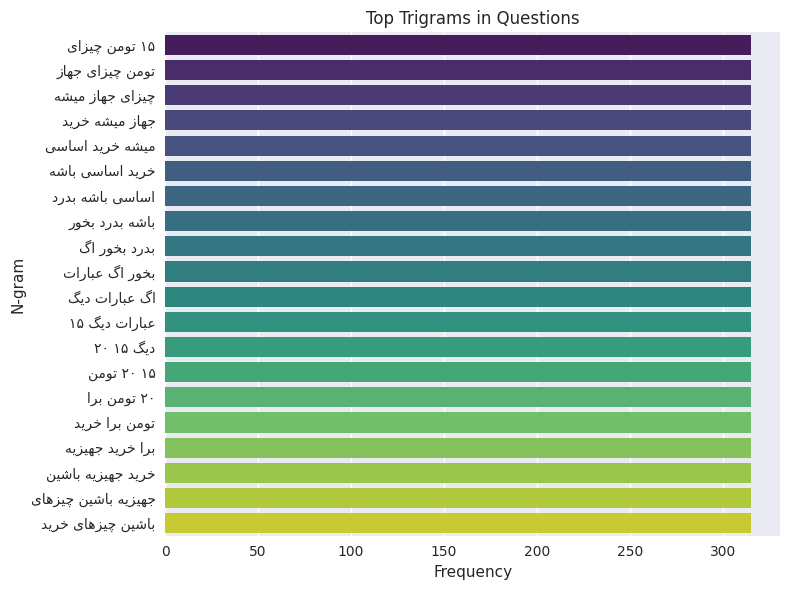

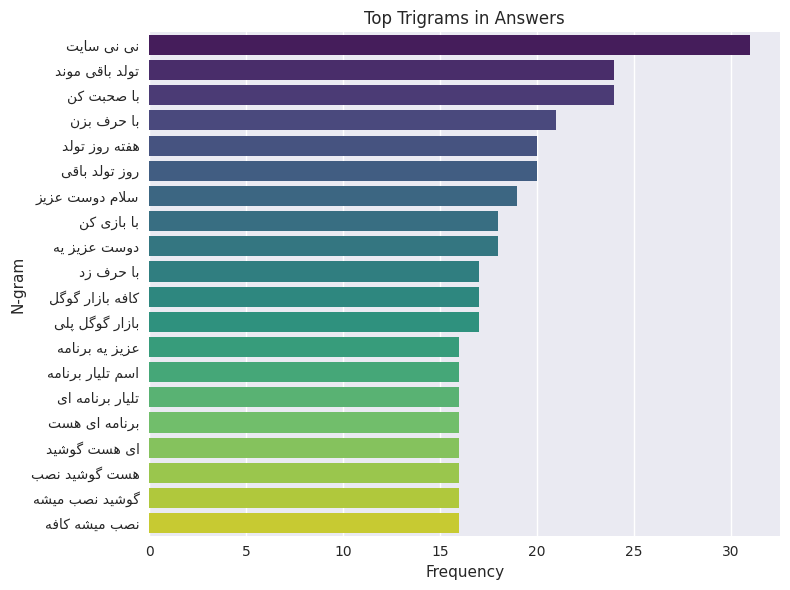

In [70]:
def plot_ngrams(ngrams, title):
    phrases, freqs = zip(*ngrams)
    reshaped_phrases = [reshape_and_display_persian(phrase) for phrase in phrases]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(freqs), y=reshaped_phrases, hue=reshaped_phrases, palette="viridis")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.tight_layout()
    plt.show()

q_unigrams = get_top_ngrams(df['clean_question_str'].dropna(), ngram_range=(1,1))
plot_ngrams(q_unigrams, "Top Unigrams in Questions")

a_unigrams = get_top_ngrams(df['clean_answer_str'].dropna(), ngram_range=(1,1))
plot_ngrams(a_unigrams, "Top Unigrams in Answers")

q_bigrams = get_top_ngrams(df['clean_question_str'].dropna(), ngram_range=(2,2))
plot_ngrams(q_bigrams, "Top Bigrams in Questions")

q_bigrams = get_top_ngrams(df['clean_answer_str'].dropna(), ngram_range=(2,2))
plot_ngrams(q_bigrams, "Top Bigrams in Answers")

q_bigrams = get_top_ngrams(df['clean_question_str'].dropna(), ngram_range=(3,3))
plot_ngrams(q_bigrams, "Top Trigrams in Questions")

a_trigrams = get_top_ngrams(df['clean_answer_str'].dropna(), ngram_range=(3,3))
plot_ngrams(a_trigrams, "Top Trigrams in Answers")


# **<span style="color: coral;">Analyse the dataset</span>**

# **<span style="color: coral;">Answer Ranking Enhancement with a Reranker</span>**